## Spam classifier
build a spam classifier using machine learning and natural language processing which can tell whether a given messege is spam or not.

In [210]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from turtle import width
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
tfidf = TfidfVectorizer()
cv = CountVectorizer()
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
ps = PorterStemmer()
encoder = LabelEncoder()

Link of dataset: https://www.kaggle.com/code/muzzzdy/sms-spam-detection-with-various-classifiers/data?select=spam.csv

## Importing Dataset

In [211]:
df = pd.read_csv('/home/milan/Downloads/spam.csv',encoding='ISO-8859-1')

In [212]:
# shape of dataset
df.shape

(5572, 5)

In [213]:
# 1. Data cleaning
# 2. EDA 
# 3. Text preprocessing
# 4. Model building
# 5. Evaluation

## 1.Data Cleaning

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [215]:
# drop the columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [216]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [217]:
# rename the column name
df.rename(columns={'v1':'Spam/Ham','v2':'SmS'},inplace=True)

### apply encoder for transform the Spam/Ham to 0 or 1

In [218]:
df['Spam/Ham'] = encoder.fit_transform(df['Spam/Ham'])

In [219]:
df.head()

,Spam/Ham,SmS
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Check the Missing values

In [220]:
# missing values
df.isnull().sum()

Spam/Ham    0
SmS         0
dtype: int64

In [221]:
# Check duplicate values
df.duplicated().sum()


403

In [222]:
# there are 403 duplicate values so we remove it
df = df.drop_duplicates(keep='first')

In [223]:
df.shape

(5169, 2)

## 2.Exploratory Data Analysis

In [224]:
# 2.EDA 
df['Spam/Ham'].value_counts()

0    4516
1     653
Name: Spam/Ham, dtype: int64

([<matplotlib.patches.Wedge at 0x7fb9625de2b0>,
 [Text(-1.0144997251399075, 0.42519443516002464, 'ham'),
  Text(1.014499764949479, -0.4251943401757036, 'spam')],
 [Text(-0.5533634864399495, 0.23192423736001339, '87.37'),
  Text(0.5533635081542612, -0.23192418555038377, '12.63')])

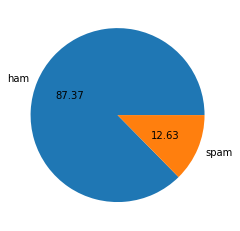

In [225]:
plt.pie(df['Spam/Ham'].value_counts(),labels=['ham','spam'],autopct='%0.2f')

In [226]:
# Data is embalanced

In [227]:
# create a numbers of characters columns
df['Num_characters'] = df['SmS'].apply(len)

In [228]:
df.head()

,Spam/Ham,SmS,Num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [229]:
# Num of words
df['Num_words'] = df['SmS'].apply(lambda x:len(nltk.word_tokenize(x)))

In [230]:
df.head()

,Spam/Ham,SmS,Num_characters,Num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [231]:
# number of sentences
df['Num_sentences'] = df['SmS'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [232]:
df.head()

,Spam/Ham,SmS,Num_characters,Num_words,Num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [233]:
df[['Num_characters','Num_words','Num_sentences']].describe()

,Num_characters,Num_words,Num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.453279,1.947185
std,58.236293,13.324793,1.362406
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,28.000000


In [234]:
df[df['Spam/Ham'] == 0][['Num_characters','Num_words','Num_sentences']].describe()

,Num_characters,Num_words,Num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.120903,1.799601
std,56.358207,13.493725,1.278465
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [235]:
df[df['Spam/Ham'] == 1][['Num_characters','Num_words','Num_sentences']].describe()

,Num_characters,Num_words,Num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


### plot the histogram of num of characters

<AxesSubplot:xlabel='Num_characters', ylabel='Count'>

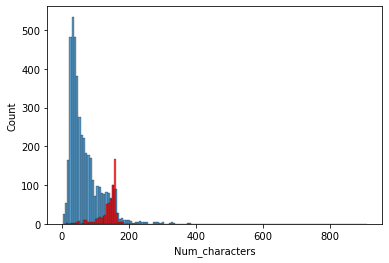

In [236]:
sns.histplot(df[df['Spam/Ham'] == 0]['Num_characters'])
sns.histplot(df[df['Spam/Ham'] == 1]['Num_characters'],color='red')

### plot histogram for num of words

<AxesSubplot:xlabel='Num_words', ylabel='Count'>

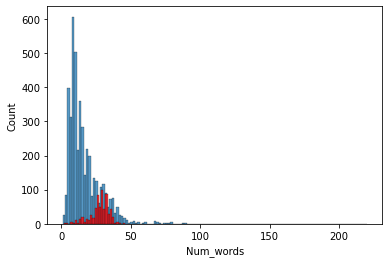

In [237]:
sns.histplot(df[df['Spam/Ham'] == 0]['Num_words'])
sns.histplot(df[df['Spam/Ham'] == 1]['Num_words'],color='red')

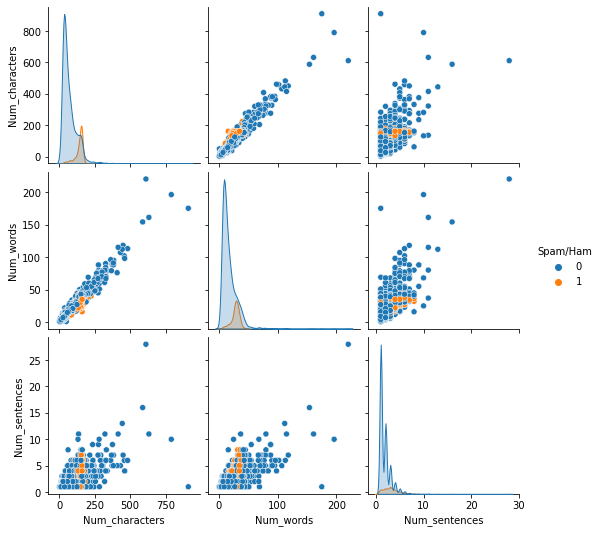

In [238]:
# plot the pairplot
sns.pairplot(df,hue='Spam/Ham')

## 3. Data preprocessing
  * Lower case
  * Tokenization
  * Removeing speacial characters
  * Stemming

In [239]:
df.head()

,Spam/Ham,SmS,Num_characters,Num_words,Num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [240]:
def transform_text(text):
    '''
    this function is do text preprocessing steps
    1. lowering the text
    2. tokenization
    3. stopwords
    '''
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    
    text = y[:]
    y.clear()


    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)



    text = y[:]
    y.clear()


    for i in text:
        y.append(ps.stem(i))
    
    
    return " ".join(y)




In [241]:
df['SmS'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [242]:
df['Tranformed_text'] = df['SmS'].apply(transform_text)

In [243]:
df.head()

,Spam/Ham,SmS,Num_characters,Num_words,Num_sentences,Tranformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


## Genrate Word cloud on Spam messeges

In [244]:
spam_wc = wc.generate(df[df['Spam/Ham']==1]['Tranformed_text'].str.cat(sep=" "))

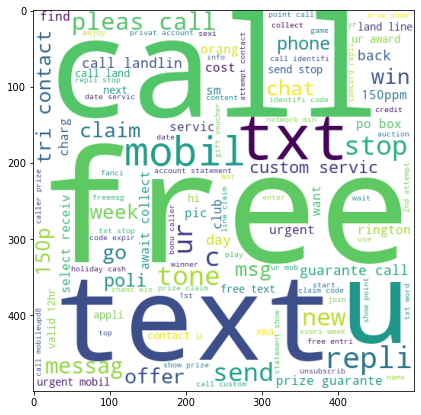

In [245]:
plt.figure(figsize=(12,7))
plt.imshow(spam_wc)

## Word cloud on Ham messeges

In [246]:
ham_wc = wc.generate(df[df['Spam/Ham']==0]['Tranformed_text'].str.cat(sep=" "))

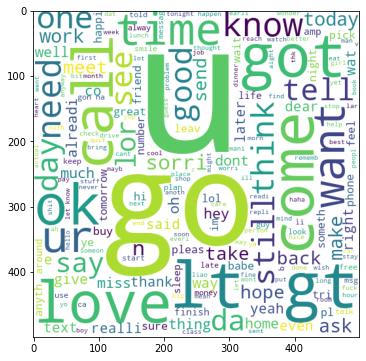

In [247]:
plt.figure(figsize=(12,6))
plt.imshow(ham_wc)

In [248]:
df.head()

,Spam/Ham,SmS,Num_characters,Num_words,Num_sentences,Tranformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [249]:
df.rename(columns={'Tranformed_text':'transformed_text'},inplace=True)

In [250]:
spam_corpus = []
for msg in df[df['Spam/Ham']==1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [251]:
len(spam_corpus)

9939

/home/milan/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'call'),
  Text(1, 0, 'free'),
  Text(2, 0, '2'),
  Text(3, 0, 'txt'),
  Text(4, 0, 'text'),
  Text(5, 0, 'u'),
  Text(6, 0, 'ur'),
  Text(7, 0, 'mobil'),
  Text(8, 0, 'stop'),
  Text(9, 0, 'repli'),
  Text(10, 0, 'claim'),
  Text(11, 0, '4'),
  Text(12, 0, 'prize'),
  Text(13, 0, 'get'),
  Text(14, 0, 'new'),
  Text(15, 0, 'servic'),
  Text(16, 0, 'tone'),
  Text(17, 0, 'send'),
  Text(18, 0, 'urgent'),
  Text(19, 0, 'nokia'),
  Text(20, 0, 'contact'),
  Text(21, 0, 'award'),
  Text(22, 0, 'phone'),
  Text(23, 0, 'cash'),
  Text(24, 0, 'pleas'),
  Text(25, 0, 'week'),
  Text(26, 0, 'win'),
  Text(27, 0, 'c'),
  Text(28, 0, 'collect'),
  Text(29, 0, 'min')])

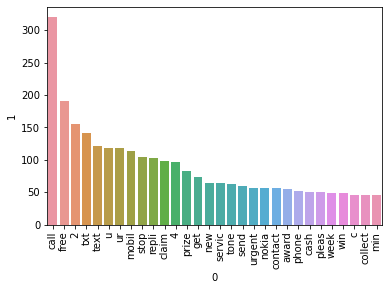

In [252]:
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0],pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')

In [253]:
ham_corpus = []
for msg in df[df['Spam/Ham']==0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

/home/milan/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'u'),
  Text(1, 0, 'go'),
  Text(2, 0, 'get'),
  Text(3, 0, 'gt'),
  Text(4, 0, 'lt'),
  Text(5, 0, '2'),
  Text(6, 0, 'come'),
  Text(7, 0, 'got'),
  Text(8, 0, 'know'),
  Text(9, 0, 'like'),
  Text(10, 0, 'call'),
  Text(11, 0, 'time'),
  Text(12, 0, 'ok'),
  Text(13, 0, 'love'),
  Text(14, 0, 'good'),
  Text(15, 0, 'want'),
  Text(16, 0, 'ur'),
  Text(17, 0, 'day'),
  Text(18, 0, 'need'),
  Text(19, 0, 'one'),
  Text(20, 0, 'lor'),
  Text(21, 0, '4'),
  Text(22, 0, 'home'),
  Text(23, 0, 'think'),
  Text(24, 0, 'see'),
  Text(25, 0, 'take'),
  Text(26, 0, 'still'),
  Text(27, 0, 'da'),
  Text(28, 0, 'tell'),
  Text(29, 0, 'make')])

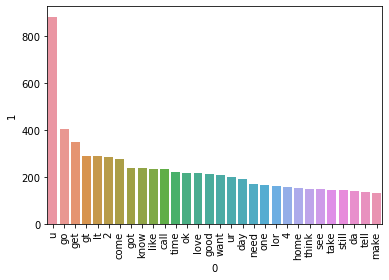

In [254]:
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0],pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')

## 4.Model Building 

### vectorization 

In [255]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [256]:
X.shape

(5169, 6708)

In [257]:
y = df['Spam/Ham'].values

In [258]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [259]:
from random import Random
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [260]:
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
from sklearn.naive_bayes import  GaussianNB,MultinomialNB,BernoulliNB
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

## 5. Model evaluation

In [261]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))


0.8762088974854932
[[793 103]
 [ 25 113]]
0.5231481481481481


In [262]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))


0.9593810444874274
[[896   0]
 [ 42  96]]
1.0


In [263]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))


0.9700193423597679
[[893   3]
 [ 28 110]]
0.9734513274336283


In [264]:
# tfidf -->mnb

In [265]:
# acc_scores,prec_score = train_classifier(clf,X_train,y_train,X_test,y_test)

### Conclusion
as per my knowledge multinomial naive bayes gives the best results
                